[View in Colaboratory](https://colab.research.google.com/github/tenvol/tsf00/blob/master/feature_crosses.ipynb)

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Feature Crosses

**Learning Objectives:**
  * Improve a linear regression model with the addition of additional synthetic features (this is a continuation of the previous exercise)
  * Use an input function to convert pandas `DataFrame` objects to `Tensors` and invoke the input function in `fit()` and `predict()` operations
  * Use the FTRL optimization algorithm for model training
  * Create new synthetic features through one-hot encoding, binning, and feature crosses

## Setup

First, as we've done in previous exercises, let's define the input and create the data-loading code.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [5]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.5,28.5,2660.3,541.3,1433.2,503.1,3.9,2.0
std,2.1,2.0,12.5,2197.3,421.7,1112.0,384.8,1.9,1.2
min,32.5,-124.3,1.0,12.0,3.0,8.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1466.0,297.0,794.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2130.0,433.5,1164.0,408.0,3.5,1.9
75%,37.7,-118.0,37.0,3167.0,651.0,1730.2,607.0,4.8,2.3
max,42.0,-114.3,52.0,32054.0,5290.0,15507.0,5050.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.7,-119.6,28.7,2603.7,534.9,1420.9,496.8,3.9,2.0
std,2.1,2.0,12.7,2137.5,421.1,1229.6,383.9,1.9,1.1
min,32.5,-124.3,2.0,2.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1449.8,295.0,779.0,280.0,2.5,1.5
50%,34.3,-118.6,29.0,2119.0,434.0,1175.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3113.0,644.0,1695.2,601.0,4.8,2.3
max,41.9,-114.5,52.0,37937.0,6445.0,35682.0,6082.0,15.0,52.0


Training targets summary:


,median_house_value
count,12000.0
mean,207.1
std,115.8
min,15.0
25%,119.8
50%,180.6
75%,263.7
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,207.7
std,116.4
min,22.5
25%,118.8
50%,179.4
75%,267.5
max,500.0


In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
chdf = california_housing_dataframe.copy()

In [8]:
for k, v in dict(chdf).items():
    print("key {} and value {}".format(k,v))


key total_bedrooms and value 1591     173.0
285      845.0
857      466.0
13277    267.0
12389    431.0
         ...  
8688     561.0
12195    159.0
5701    1504.0
14574    161.0
15947    977.0
Name: total_bedrooms, Length: 17000, dtype: float64
key median_income and value 1591    7.4
285     4.2
857     1.6
13277   3.7
12389   3.9
         ..
8688    4.4
12195   3.2
5701    9.8
14574   2.9
15947   5.1
Name: median_income, Length: 17000, dtype: float64
key households and value 1591     190.0
285      769.0
857      488.0
13277    265.0
12389    421.0
         ...  
8688     517.0
12195    160.0
5701    1482.0
14574    154.0
15947    952.0
Name: households, Length: 17000, dtype: float64
key housing_median_age and value 1591    52.0
285     17.0
857     21.0
13277   52.0
12389   22.0
        ... 
8688    34.0
12195   52.0
5701    32.0
14574   46.0
15947   40.0
Name: housing_median_age, Length: 17000, dtype: float64
key longitude and value 1591    -117.2
285     -116.8
857     -117.1
1327

In [0]:
feature = {k:np.array(v) for k, v in dict(chdf).items()}

In [10]:
feature

{'households': array([ 190.,  769.,  488., ..., 1482.,  154.,  952.]),
 'housing_median_age': array([52., 17., 21., ..., 32., 46., 40.]),
 'latitude': array([32.74, 32.85, 32.59, ..., 34.22, 37.75, 37.75]),
 'longitude': array([-117.22, -116.75, -117.07, ..., -118.19, -122.16, -122.43]),
 'median_house_value': array([345700., 217400.,  96200., ..., 500001., 142900., 356100.]),
 'median_income': array([7.4029, 4.2321, 1.6007, ..., 9.8413, 2.925 , 5.0519]),
 'population': array([ 436., 2266., 1327., ..., 4353.,  429., 1824.]),
 'total_bedrooms': array([ 173.,  845.,  466., ..., 1504.,  161.,  977.]),
 'total_rooms': array([ 1283.,  4863.,  1779., ..., 10626.,   954.,  4850.])}

In [11]:
feature['households']

array([ 190.,  769.,  488., ..., 1482.,  154.,  952.])

In [12]:
dict(chdf).keys()

['total_bedrooms',
 'median_income',
 'households',
 'housing_median_age',
 'longitude',
 'total_rooms',
 'latitude',
 'median_house_value',
 'population']

In [0]:
kyes = dict(chdf).keys()

In [14]:
kyes

['total_bedrooms',
 'median_income',
 'households',
 'housing_median_age',
 'longitude',
 'total_rooms',
 'latitude',
 'median_house_value',
 'population']

In [15]:
chdf.columns

Index([u'longitude', u'latitude', u'housing_median_age', u'total_rooms',
       u'total_bedrooms', u'population', u'households', u'median_income',
       u'median_house_value'],
      dtype='object')

In [16]:
xc = np.array([item['fea'][0] for item in feature['households']])

IndexError: ignored

In [17]:
feature['households']

array([ 190.,  769.,  488., ..., 1482.,  154.,  952.])

In [18]:
for item in feature['households']:
  xc = np.array(item[0])
  #print(item)
  print(xc)

IndexError: ignored

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
fc = construct_feature_columns(training_examples)

In [22]:
type(fc)

set

In [23]:
fc

{_NumericColumn(key='households', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='population', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='rooms_per_person', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='total_bedrooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)}

In [24]:
for s in fc:
  print(s)

_NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
_NumericColumn(key='rooms_per_person', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
_NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
_NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
_NumericColumn(key='households', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
_NumericColumn(key='total_bedrooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
_NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
_NumericColumn(key='population', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
_NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)


## FTRL Optimization Algorithm

High dimensional linear models benefit from using a variant of gradient-based optimization called FTRL. This algorithm has the benefit of scaling the learning rate differently for different coefficients, which can be useful if some features rarely take non-zero values (it also is well suited to support L1 regularization). We can apply FTRL using the [FtrlOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/FtrlOptimizer).

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    feature_columns: A `set` specifying the input feature columns to use.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    
    print("type is ", type(training_predictions))
    
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
type is  <type 'generator'>
  period 00 : 131.64
type is  <type 'generator'>
  period 01 : 121.32
type is  <type 'generator'>
  period 02 : 108.89
type is  <type 'generator'>
  period 03 : 106.78
type is  <type 'generator'>
  period 04 : 106.44
type is  <type 'generator'>
  period 05 : 108.76
type is  <type 'generator'>
  period 06 : 106.37
type is  <type 'generator'>
  period 07 : 109.04
type is  <type 'generator'>
  period 08 : 109.42
type is  <type 'generator'>
  period 09 : 105.24
Model training finished.


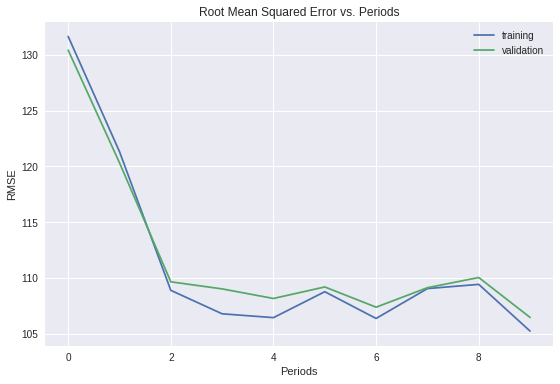

In [27]:
_ = train_model(
    learning_rate=0.1,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## One-Hot Encoding for Discrete Features

Discrete (i.e. strings, enumerations, integers) features are usually converted into families of binary features before training a logistic regression model.

For example, suppose we created a synthetic feature that can take any of the values `0`, `1` or `2`, and that we have a few training points:

| # | feature_value |
|---|---------------|
| 0 |             2 |
| 1 |             0 |
| 2 |             1 |

For each possible categorical value, we make a new **binary** feature of **real values** that can take one of just two possible values: 1.0 if the example has that value, and 0.0 if not. In the example above, the categorical feature would be converted into three features, and the training points now look like:

| # | feature_value_0 | feature_value_1 | feature_value_2 |
|---|-----------------|-----------------|-----------------|
| 0 |             0.0 |             0.0 |             1.0 |
| 1 |             1.0 |             0.0 |             0.0 |
| 2 |             0.0 |             1.0 |             0.0 |

## Bucketized (Binned) Features

Bucketization is also known as binning.

We can bucketize `population` into the following 3 buckets (for instance):
- `bucket_0` (`< 5000`): corresponding to less populated blocks
- `bucket_1` (`5000 - 25000`): corresponding to mid populated blocks
- `bucket_2` (`> 25000`): corresponding to highly populated blocks

Given the preceding bucket definitions, the following `population` vector:

    [[10001], [42004], [2500], [18000]]

becomes the following bucketized feature vector:

    [[1], [2], [0], [1]]

The feature values are now the bucket indices. Note that these indices are considered to be discrete features. Typically, these will be further converted in one-hot representations as above, but this is done transparently.

To define feature columns for bucketized features, instead of using `numeric_column`, we can use [`bucketized_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column), which takes a numeric column as input and transforms it to a bucketized feature using the bucket boundaries specified in the `boundardies` argument. The following code defines bucketized feature columns for `households` and `longitude`; the `get_quantile_based_boundaries` function calculates boundaries based on quantiles, so that each bucket contains an equal number of elements.

In [39]:
def get_quantile_based_boundaries(feature_values, num_buckets):
  boundaries = np.arange(1.0, num_buckets) / num_buckets
  print(boundaries)
  quantiles = feature_values.quantile(boundaries)
  #print("quantiles ", quantiles)
  return [quantiles[q] for q in quantiles.keys()]

# Divide households into 7 buckets.
households = tf.feature_column.numeric_column("households")
print(households)
bucketized_households = tf.feature_column.bucketized_column(
  households, boundaries=get_quantile_based_boundaries(
    california_housing_dataframe["households"], 7))

# Divide longitude into 10 buckets.
longitude = tf.feature_column.numeric_column("longitude")
bucketized_longitude = tf.feature_column.bucketized_column(
  longitude, boundaries=get_quantile_based_boundaries(
    california_housing_dataframe["longitude"], 10))

_NumericColumn(key='households', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [40]:
bucketized_households

_BucketizedColumn(source_column=_NumericColumn(key='households', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(220.0, 300.0, 371.0, 451.0, 567.0, 769.0))

In [41]:
get_quantile_based_boundaries(california_housing_dataframe['population'], 10)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


[514.0,
 712.0,
 860.0,
 1008.0,
 1167.0,
 1347.0,
 1575.0,
 1905.0,
 2578.2000000000007]

In [32]:
california_housing_dataframe.quantile([0.1,0.5,0.9]).keys()

Index([u'longitude', u'latitude', u'housing_median_age', u'total_rooms',
       u'total_bedrooms', u'population', u'households', u'median_income',
       u'median_house_value'],
      dtype='object')

In [42]:
bucketized_households

_BucketizedColumn(source_column=_NumericColumn(key='households', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(220.0, 300.0, 371.0, 451.0, 567.0, 769.0))

In [43]:
bucketized_longitude

_BucketizedColumn(source_column=_NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(-122.28, -121.98, -121.36000000000001, -119.87, -118.49, -118.3, -118.12, -117.88, -117.24))

In [0]:
num_buckets = 7

In [45]:
np.arange(1.0, 7)

array([1., 2., 3., 4., 5., 6.])

In [46]:
np.arange(1.0, num_buckets) / num_buckets

array([0.14285714, 0.28571429, 0.42857143, 0.57142857, 0.71428571,
       0.85714286])

In [47]:
california_housing_dataframe['households'].quantile([0.25, 0.5, 0.75])

0.2   282.0
0.5   409.0
0.8   605.2
Name: households, dtype: float64

In [48]:
california_housing_dataframe['households'].quantile(np.arange(1.0,7)/7)

0.1   220.0
0.3   300.0
0.4   371.0
0.6   451.0
0.7   567.0
0.9   769.0
Name: households, dtype: float64

In [49]:
california_housing_dataframe['households'].describe()

count   17000.0
mean      501.2
std       384.5
min         1.0
25%       282.0
50%       409.0
75%       605.2
max      6082.0
Name: households, dtype: float64

In [50]:
np.arange(1.0, 9)/9

array([0.11111111, 0.22222222, 0.33333333, 0.44444444, 0.55555556,
       0.66666667, 0.77777778, 0.88888889])

In [0]:
xquan = california_housing_dataframe['households'].quantile(np.arange(1.0,7)/7)

In [72]:
{xquan[k] for k in xquan.keys()}

{220.0, 300.0, 371.0, 451.0, 567.0, 769.0}

In [78]:
tf.feature_column.numeric_column("fur")

_NumericColumn(key='fur', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

## Task 1: Train the Model on Bucketized Feature Columns
**Bucketize all the real valued features in our example, train the model and see if the results improve.**

In the preceding code block, two real valued columns (namely `households` and `longitude`) have been transformed into bucketized feature columns. Your task is to bucketize the rest of the columns, then run the code to train the model. There are various heuristics to find the range of the buckets. This exercise uses a quantile-based technique, which chooses the bucket boundaries in such a way that each bucket has the same number of examples.

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))

  #
  # YOUR CODE HERE: bucketize the following columns, following the example above:
  #
  bucketized_latitude = tf.feature_column.bucketized_column(
      latitude, boundaries=get_quantile_based_boundaries(
      training_examples['latitude'], 10) )
  
  bucketized_housing_median_age =  tf.feature_column.bucketized_column(
      housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples['housing_median_age'], 10) )
  
  bucketized_median_income =  tf.feature_column.bucketized_column(
      median_income, boundaries=get_quantile_based_boundaries(
      training_examples['median_income'], 12) )
  
  bucketized_rooms_per_person =  tf.feature_column.bucketized_column(
      rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples['rooms_per_person'], 5) )
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])

  print(feature_columns)
  
  return feature_columns


In [55]:
xfc = construct_feature_columns()

[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.08333333 0.16666667 0.25       0.33333333 0.41666667 0.5
 0.58333333 0.66666667 0.75       0.83333333 0.91666667]
[0.2 0.4 0.6 0.8]
set([_BucketizedColumn(source_column=_NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(-122.28, -121.97, -121.35, -119.83, -118.47, -118.29, -118.11700000000002, -117.88, -117.24)), _BucketizedColumn(source_column=_NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(33.61, 33.86, 33.99, 34.09, 34.23, 36.604, 37.46, 37.8, 38.48)), _BucketizedColumn(source_column=_NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.7928749999999998, 2.2222, 2.5769, 2.9026999999999994, 3.2045500000000002

In [57]:
xfc

{_BucketizedColumn(source_column=_NumericColumn(key='households', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(222.0, 300.0, 371.0, 452.0, 568.0, 772.0)),
 _BucketizedColumn(source_column=_NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(12.0, 17.0, 20.0, 25.0, 29.0, 33.0, 36.0, 39.0, 46.0)),
 _BucketizedColumn(source_column=_NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(33.61, 33.86, 33.99, 34.09, 34.23, 36.604, 37.46, 37.8, 38.48)),
 _BucketizedColumn(source_column=_NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(-122.28, -121.97, -121.35, -119.83, -118.47, -118.29, -118.11700000000002, -117.88, -117.24)),
 _BucketizedColumn(source_column=_NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),

[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.08333333 0.16666667 0.25       0.33333333 0.41666667 0.5
 0.58333333 0.66666667 0.75       0.83333333 0.91666667]
[0.2 0.4 0.6 0.8]
set([_BucketizedColumn(source_column=_NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(-122.28, -121.97, -121.35, -119.83, -118.47, -118.29, -118.11700000000002, -117.88, -117.24)), _BucketizedColumn(source_column=_NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(33.61, 33.86, 33.99, 34.09, 34.23, 36.604, 37.46, 37.8, 38.48)), _BucketizedColumn(source_column=_NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.7928749999999998, 2.2222, 2.5769, 2.9026999999999994, 3.2045500000000002

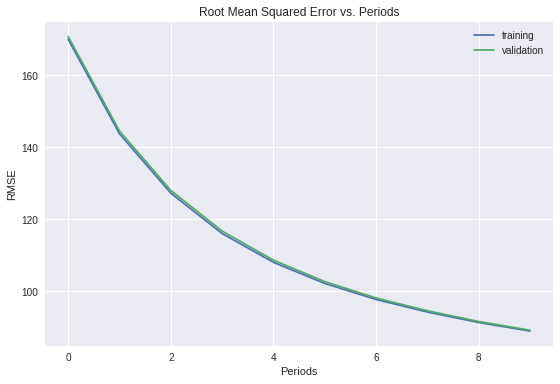

In [54]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### Solution

Click below for a solution.

You may be wondering how to determine how many buckets to use. That is of course data-dependent. Here, we just selected arbitrary values so as to obtain a not-too-large model.

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
  return feature_columns

In [88]:
bucketized_longitude.source_column.count

<function count>

In [79]:
bucketized_households.index

<function index>

In [95]:
for x in bucketized_households.boundaries:
  print(x)

220.0
300.0
371.0
451.0
567.0
769.0


In [134]:
for x, y in bucketized_households.boundaries, bucketized_longitude.boundaries:
  print(x, y)

ValueError: ignored

In [136]:
tf.feature_column.numeric_column('price')

_NumericColumn(key='price', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [0]:
tmp = tf.feature_column.categorical_column_with_identity('pid', 30)

In [140]:
tmp

_IdentityCategoricalColumn(key='pid', num_buckets=30, default_value=None)

In [0]:
tmp = tf.feature_column.crossed_column(['1', '3', '2'], ['a', 'b', 't', 'g'], 12)

In [129]:
type(tmp)

tensorflow.python.feature_column.feature_column._CrossedColumn

In [130]:
tmp

_CrossedColumn(keys=('1', '3', '2'), hash_bucket_size=['a', 'b', 't', 'g'], hash_key=12)

In [101]:
bucketized_households.boundaries

(220.0, 300.0, 371.0, 451.0, 567.0, 769.0)

In [0]:
a = []
for x in bucketized_households.boundaries:
  for y in bucketized_longitude.boundaries:
    #print(x,y)
    a.append((x,y))

In [115]:
a[20:23], len(a)

([(371.0, -121.36000000000001), (371.0, -119.87), (371.0, -118.49)], 54)

In [117]:
len(bucketized_households.boundaries)

6

In [118]:
len(bucketized_longitude.boundaries)

9

[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
Training model...
RMSE (on training data):
type is  <type 'generator'>
  period 00 : 169.23
type is  <type 'generator'>
  period 01 : 142.93
type is  <type 'generator'>
  period 02 : 126.54
type is  <type 'generator'>
  period 03 : 115.52
type is  <type 'generator'>
  period 04 : 107.63
type is  <type 'generator'>
  period 05 : 101.87
type is  <type 'generator'>
  period 06 : 97.34
type is  <type 'generator'>
  period 07 : 93.76
type is  <type 'generator'>
  period 08 : 90.90
type is  <type 'generator'>
  period 09 : 88.56
Model training finished.


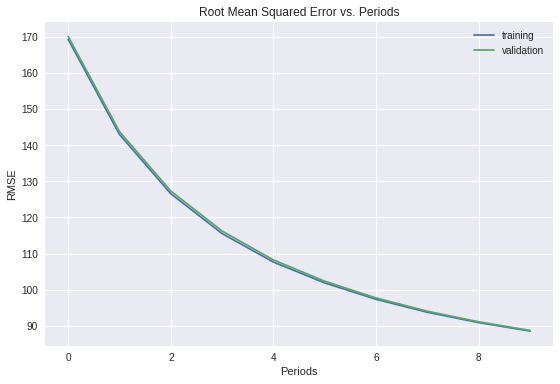

In [102]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Feature Crosses

Crossing two (or more) features is a clever way to learn non-linear relations using a linear model. In our problem, if we just use the feature `latitude` for learning, the model might learn that city blocks at a particular latitude (or within a particular range of latitudes since we have bucketized it) are more likely to be expensive than others. Similarly for the feature `longitude`. However, if we cross `longitude` by `latitude`, the crossed feature represents a well defined city block. If the model learns that certain city blocks (within range of latitudes and longitudes) are more likely to be more expensive than others, it is a stronger signal than two features considered individually.

Currently, the feature columns API only supports discrete features for crosses. To cross two continuous values, like `latitude` or `longitude`, we can bucketize them.

If we cross the `latitude` and `longitude` features (supposing, for example, that `longitude` was bucketized into `2` buckets, while `latitude` has `3` buckets), we actually get six crossed binary features. Each of these features will get its own separate weight when we train the model.

## Task 2: Train the Model Using Feature Crosses

**Add a feature cross of `longitude` and `latitude` to your model, train it, and determine whether the results improve.**

Refer to the TensorFlow API docs for [`crossed_column()`](https://www.tensorflow.org/api_docs/python/tf/feature_column/crossed_column) to build the feature column for your cross. Use a `hash_bucket_size` of `1000`.

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  # YOUR CODE HERE: Make a feature column for the long_x_lat feature cross
  l_x_l = tf.feature_column.categorical_column_with_identity('l_x_l', 10)
  long_x_lat = tf.feature_column.crossed_column([bucketized_longitude, bucketized_latitude], 120)
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person,
    long_x_lat])
  
  return feature_columns

In [215]:
bucketized_longitude.boundaries

(-122.28,
 -121.98,
 -121.36000000000001,
 -119.87,
 -118.49,
 -118.3,
 -118.12,
 -117.88,
 -117.24)

In [0]:
 l_x_l = tf.feature_column.categorical_column_with_identity('l_x_l', 10)

In [217]:
l_x_l

_IdentityCategoricalColumn(key='l_x_l', num_buckets=10, default_value=None)

[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
Training model...
RMSE (on training data):
type is  <type 'generator'>
  period 00 : 162.83
type is  <type 'generator'>
  period 01 : 134.65
type is  <type 'generator'>
  period 02 : 117.73
type is  <type 'generator'>
  period 03 : 106.69
type is  <type 'generator'>
  period 04 : 99.00
type is  <type 'generator'>
  period 05 : 93.30
type is  <type 'generator'>
  period 06 : 89.02
type is  <type 'generator'>
  period 07 : 85.53
type is  <type 'generator'>
  period 08 : 82.72
type is  <type 'generator'>
  period 09 : 80.46
Model training finished.


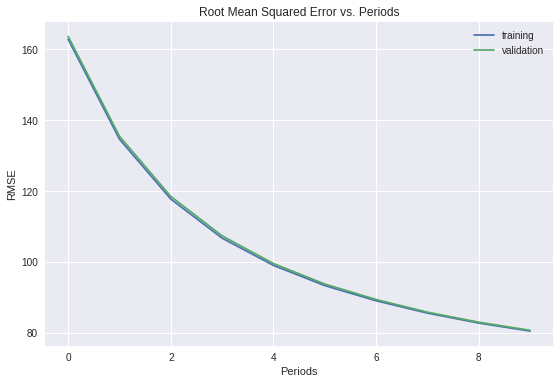

In [218]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### Solution

Click below for the solution.

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  # YOUR CODE HERE: Make a feature column for the long_x_lat feature cross
  long_x_lat = tf.feature_column.crossed_column(
  set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000) 
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person,
    long_x_lat])
  
  return feature_columns

[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
Training model...
RMSE (on training data):
type is  <type 'generator'>
  period 00 : 163.45
type is  <type 'generator'>
  period 01 : 135.35
type is  <type 'generator'>
  period 02 : 118.39
type is  <type 'generator'>
  period 03 : 107.21
type is  <type 'generator'>
  period 04 : 99.48
type is  <type 'generator'>
  period 05 : 93.73
type is  <type 'generator'>
  period 06 : 89.36
type is  <type 'generator'>
  period 07 : 85.93
type is  <type 'generator'>
  period 08 : 83.12
type is  <type 'generator'>
  period 09 : 80.78
Model training finished.


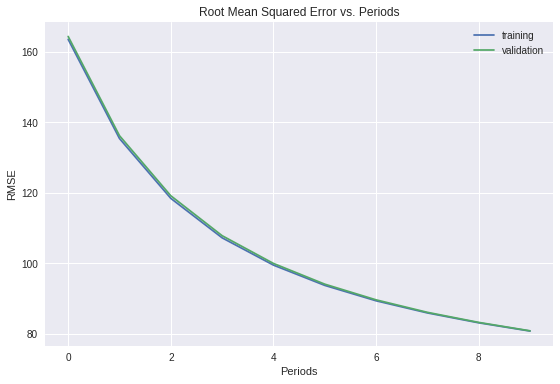

In [213]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Optional Challenge: Try Out More Synthetic Features

So far, we've tried simple bucketized columns and feature crosses, but there are many more combinations that could potentially improve the results. For example, you could cross multiple columns. What happens if you vary the number of buckets? What other synthetic features can you think of? Do they improve the model?

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 20))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 20))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  # YOUR CODE HERE: Make a feature column for the long_x_lat feature cross
  l_x_l = tf.feature_column.categorical_column_with_identity('l_x_l', 10)
  long_x_lat = tf.feature_column.crossed_column([bucketized_longitude, bucketized_latitude], 120)
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person,
    long_x_lat])
  
  return feature_columns

[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
Training model...
RMSE (on training data):
type is  <type 'generator'>
  period 00 : 167.12
type is  <type 'generator'>
  period 01 : 139.09
type is  <type 'generator'>
  period 02 : 121.59
type is  <type 'generator'>
  period 03 : 109.69
type is  <type 'generator'>
  period 04 : 101.16
type is  <type 'generator'>
  period 05 : 94.89
type is  <type 'generator'>
  period 06 : 90.05
type is  <type 'generator'>
  period 07 : 86.12
type is  <type 'generator'>
  period 08 : 83.04
type is  <type 'generator'>
  period 09 : 80.44
Model 

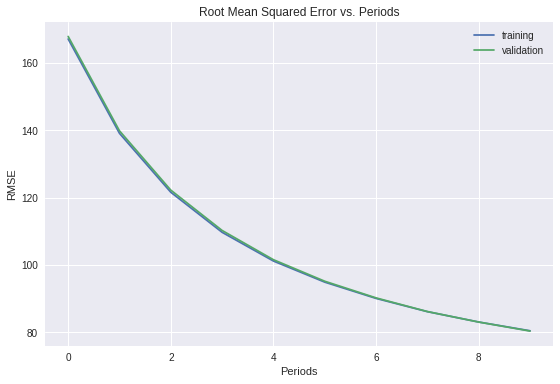

In [220]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
[0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
Training model...
RMSE (on training data):
type is  <type 'generator'>
  period 00 : 166.91
type is  <type 'generator'>
  period 01 : 138.85
type is  <type 'generator'>
  period 02 : 121.36
type is  <type 'generator'>
  period 03 : 109.55
type is  <type 'generator'>
  period 04 : 101.08
type is  <type 'generator'>
  period 05 : 94.68
type is  <type 'generator'>
  period 06 : 89.82
type is  <type 'generator'>
  period 07 : 85.93
type is  <type 'generator'>
  period 08 : 82.85
type is  <type 'generator'>
  period 09 : 80.21
Model 

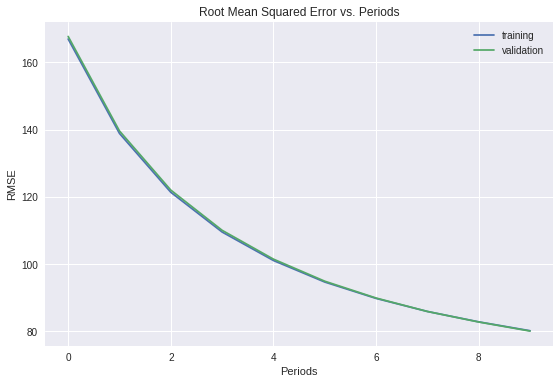

In [221]:
ximproved = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)